In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yt
yt.mylog.setLevel("ERROR")
import warnings
warnings.filterwarnings('ignore')

This jupyter notebook will demonstrate the methodology described in Heinrich et al. 2021 for the quantification of x-ray surface brightness fluctuations due to black hole feedback in simulated galaxy clusters, in this case the Chen et al. 2019 simulation tuned to match the properties of the Perseus Cluster. This work puts new constraints on the cooling flow gap between observed and expected cooling rates of the intracluster medium (ICM).

The first step is thus to examine the simulation data in itself and prepare it for analysis. Included in this directory are several snapshots of the simulation, marked by their age. In this simulation, the jet fires for 10 Myr and is allowed to propagate throughout the cluster for many Myr more.


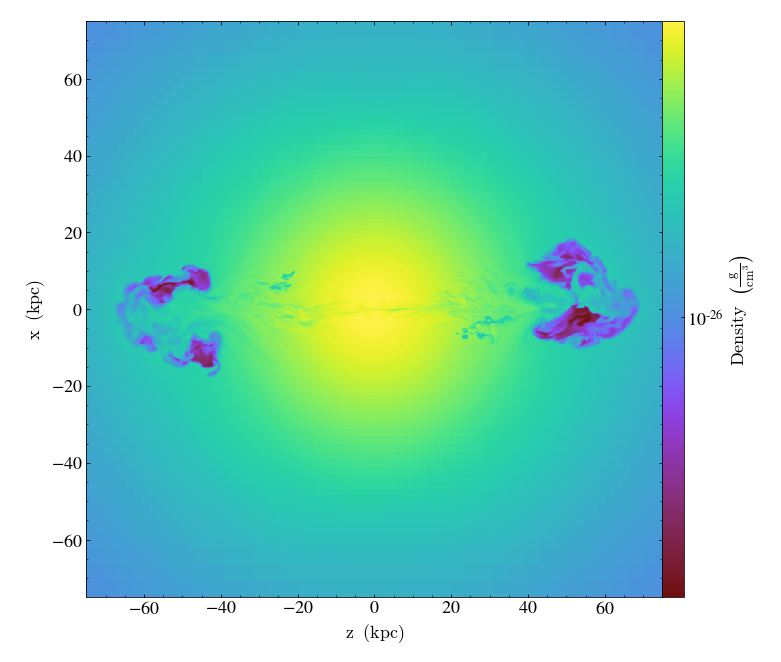

In [2]:
# We use the yt package to analyse the simulation datasets.
# Let's load one now.
ds=yt.load('perseus_80Myr')
# ds is a 3-d dataset object with multiple fields stored. 
# Let's practice visualizing this data with a slice plot.
slc=yt.SlicePlot(ds, 'y', 'density', center=[0,0,0],width=(150,'kpc'))
# This slice plot will be perpendicular to the y-axis, centered at
# the origin (aka the black hole), and be 150 kpc wide.
slc.show()

This slice plot is simply a 2-dimensional plane taken from from the 3-d dataset. This one cuts straight through the jet because it is centered at the origin. If we wanted to move it out of the jet, we can do so by adjusting the center.


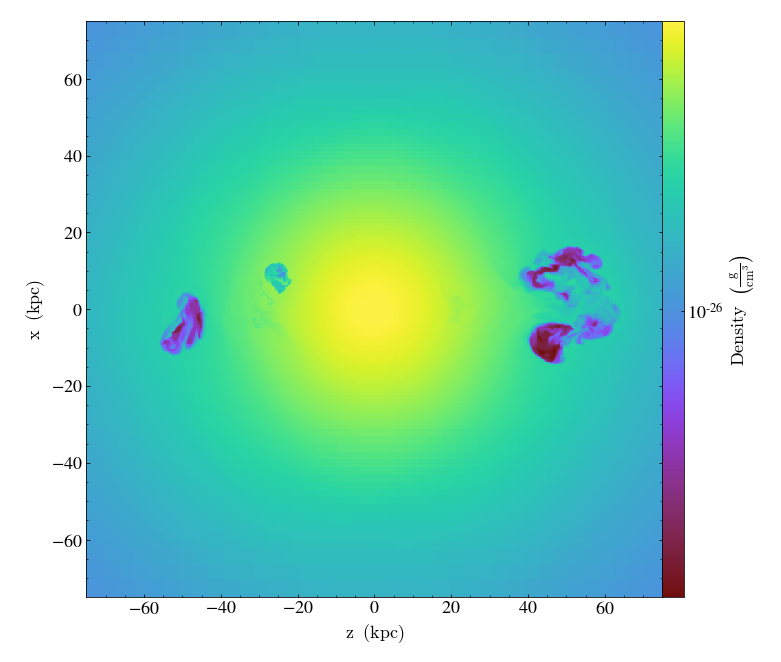

In [3]:
slc=yt.SlicePlot(ds, 'y', 'density',
                 center=([0,10,0],'kpc'), width=(150,'kpc'))
slc.show()

We have moved the y-axis 10 kpc in in this image, essentially dollying the camera forward. Now we see the outer plume of the jet instead of its center. We can do this for any number of positions in the simulation.
What if we wanted to see all of these slice plots at once? We can sum over each plane in the simulation in order to get a better view of the entire domain.


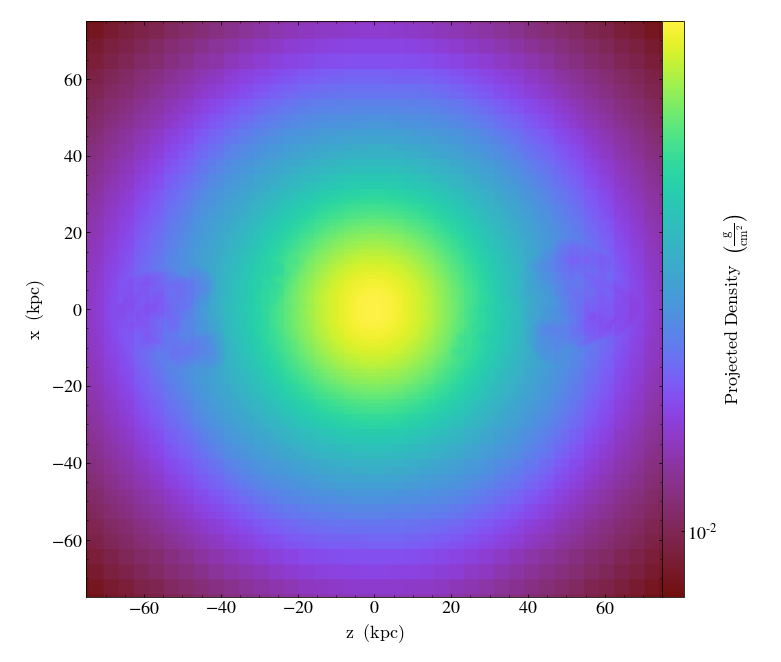

In [4]:
# The easiest way to do this is yt's built-in ProjectionPlot.
proj=yt.ProjectionPlot(ds, 'y','density',
                       center=([0,0,0],'kpc'), width=(150,'kpc'))
proj.show()

If we use a projection plot on the X-ray emissivity of the simulation, we can view a facsimile of what an observatory like Chandra will see. The X-ray emissivity is not stored by the simulation, but we can calculate it using an APEC table. The APEC code calculates emissivity based on the simulations other fields (density, temperature, etc.) and metallicities from Anders & Grevesse (1989).


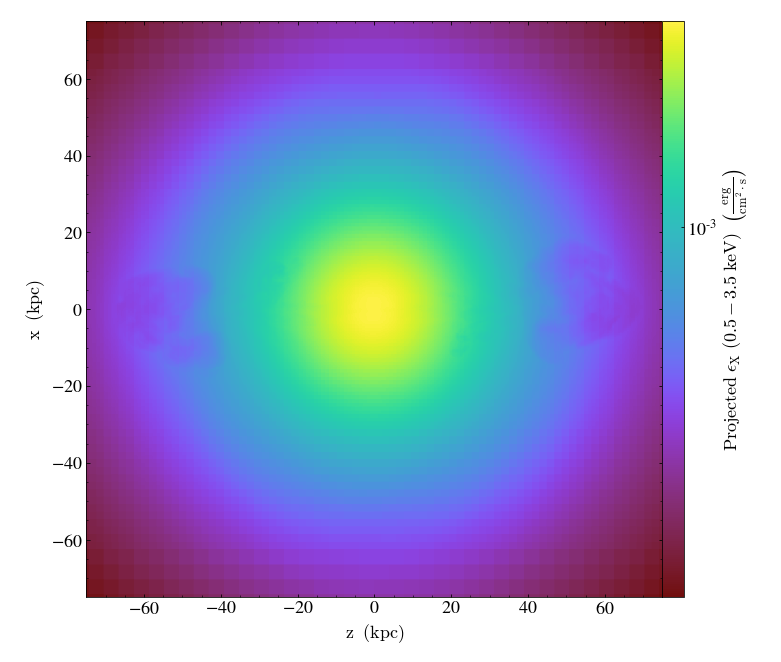

In [5]:
emis, l, pemis=yt.add_xray_emissivity_field(ds, 0.5, 3.5,
                                        table_type='apec', metallicity=.5)
# We have set the emissivity to include photons between 0.5 and 3.5 keV,
# soft X-rays, matching Chandra's observable energies. We have also assumed
# the cluster has metallicity of half the solar value.
proj=yt.ProjectionPlot(ds, 'y', emis,
                       center=([0,0,0],'kpc'), width=(150,'kpc'))
proj.show()

This doesn't look half bad! However, we can do much better in terms of our methods. Let's use a more involved method for the projection plot, much more customizable. We want a higher resolution image for starters. There is also a clear grid artifact around the edges of the above image. This is caused by the AMR grid, which has a different cell resolution for different regions of the cluster. This is going to cause some problems later, so let's fix it now.

In [6]:
# We'll make a series of functions for different projection methods.
# The first simply attempts to handle the resolution controls, for which we
# will use level to represent the minimum cell level to include.
def projection(ds, width, res):
    emis, l, pemis=yt.add_xray_emissivity_field(ds, 0.5, 3.5,
                                        table_type='apec', metallicity=.5)
    
    proj=ds.proj(emis, axis='y')
    # This performs the projection by summing over the entire domain.
    frb=proj.to_frb((width,'kpc'), [res,res], center=[0,0,0])
    # This applies a Fixed Resolution Buffer, which specifies a resolution
    # and changes the simulation's AMR grid to fit that resolution.
    arr=np.array(frb[emis])
    return arr

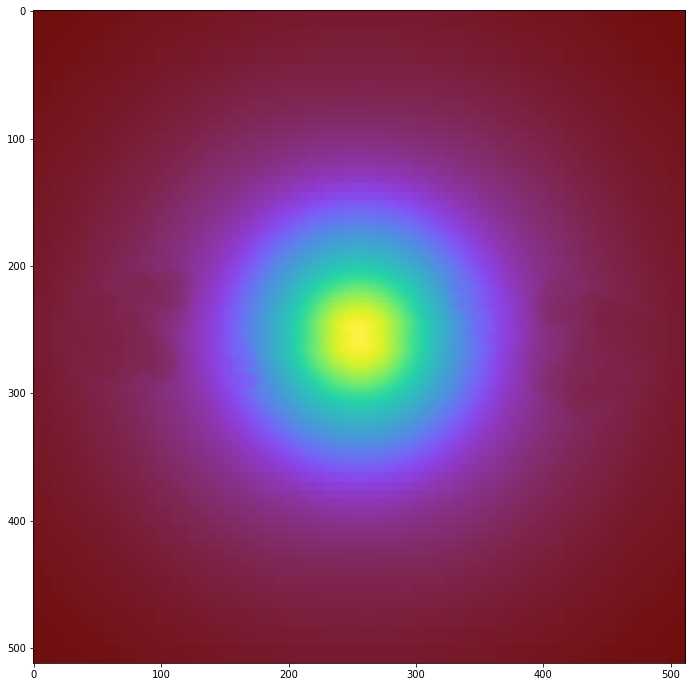

In [7]:
proj=projection(ds, width=150, res=512)
plt.figure(figsize=(12,12))
plt.imshow(proj)
# We now have the projection as a numpy array, which allows us to do a lot 
# more analysis easier than with yt's built-in visualization datatype. 
plt.set_cmap('arbre')
# We can set the colormap to 'arbre' in matplotlib, 
# which is the default that yt uses.

This image is a much higher resolution, but still doesn't fix the grid issue. To do that, we need to replace our FixedResolutionBuffer function with a Smoothed Covering Grid. This serves the same purpose but smooths the grid lines between AMR cells by interpolating across them. This will make our image much more physical.

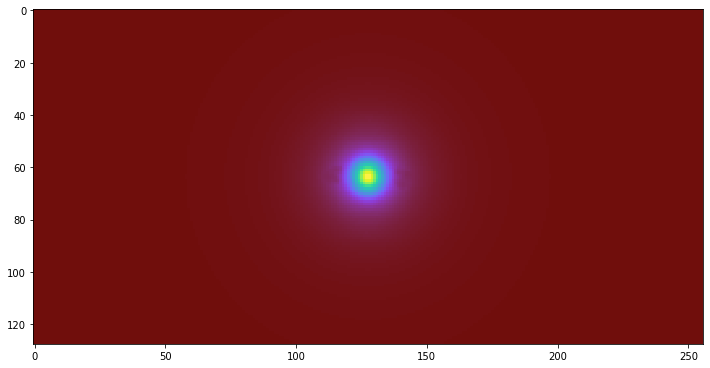

In [8]:
# Let's make another function to remove the grid.
from yt.units import kpc
# We will have to import kpc for this projection. This is a yt unit object.
def projection_no_grid(ds, level=0, direction=1):
    # The SCG has to be perfectly aligned with the AMR grid, so we can no
    # longer specify any resolution we want. We have to specify the maximum
    # level of AMR cell to include. In these simulations, level 4 gives
    # a 512x512 image for the entire domain.
    ds.periodicity=(True,True,True)
    #This must be set, otherwise the SCG overlapping with the domain edge
    #is going to cause an error.
    l_edge=ds.domain_left_edge
    #This is the most negative point in the simulation in three 
    #dimensions. In this case it is [-250, -250, -500] kpc
    emis, l, pemis= yt.add_xray_emissivity_field(ds, 0.5, 3.5,
                                        table_type='apec', metallicity=.5)
    dims=ds.domain_dimensions
    scg=ds.smoothed_covering_grid(level, l_edge, dims*2**(level))
    # This is the smoothed covering grid object, which is currently in 3D.
    # To project over it, we'll sum over the specified axis. The direction
    # argument specifies the axis, with 0:x, 1:y, 2:z
    proj=np.array(np.sum(scg[emis], axis=direction))
    return proj
proj=projection_no_grid(ds, level=1)
plt.figure(figsize=(12,12))
plt.imshow(proj)
# This can produce smoother images without the grid artifact, however it
# both takes more processing and doesn't scale well. If we try to increase
# the resolution even more, we will run into a memory limit.

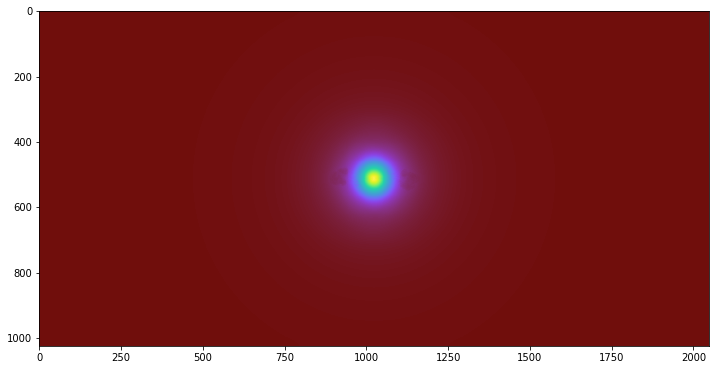

In [9]:
#The SCG data object has quite a lot of information stored, and so will
#quickly take up the entire memory of our system if we keep increasing the
#resolution level. We can get around this by doing the projection in bits.
#We divide the simulation domain into octants, one for each corner.
def concatenating_projection(ds, level=0, direction=2):
    # First we make an empty list of lists to store each octant.
    # The list is 2x2x2, just as our divided domain is.
    projections=[[['#' for n in range(2)] for n in range(2)] for n in range(2)]
    ds.periodicity=(True, True, True)
    # This sets the boundary conditions for the simulation.
    # This must be included otherwise the SCG will be outside the simulation domain.
    emis, lumis, pemis = yt.add_xray_emissivity_field(ds, 0.5, 3.5,
                                        table_type='apec', metallicity=0.5)
    l_edge=ds.domain_left_edge
    dimensions=ds.domain_dimensions
    # The below for loop does a lot of the heavy lifting here.
    # We change each coordinate of the left edge to select the appropriate octant.
    for i in range(2):
        for j in range(2):
            for k in range(2):
                scg=ds.smoothed_covering_grid(level,
                                [l_edge[0]*i, l_edge[1]*j, l_edge[2]*k], 
                                dimensions*2**(level-1))
                proj=np.array(np.sum(scg[emis], axis=direction))
                projections[i][j][k]=proj
    # Now we add together octants along the sight line and concatenate the
    # adjacent octants. This has to be done differently for each projection
    # axis, which has been worked out and programmed below.
    if direction==2:
        top=np.concatenate((projections[1][1][1]+projections[1][1][0],
                            projections[1][0][1]+projections[1][0][0]), axis=1)
        bot=np.concatenate((projections[0][1][1]+projections[0][1][0], 
                            projections[0][0][1]+projections[0][0][0]), axis=1)
        proj=np.concatenate((top,bot), axis=0)
        return proj
    if direction==1:
        top=np.concatenate((projections[1][1][1]+projections[1][0][1], 
                            projections[1][1][0]+projections[1][0][0]), axis=1)
        bot=np.concatenate((projections[0][1][1]+projections[0][0][1], 
                            projections[0][1][0]+projections[0][0][0]), axis=1)
        proj=np.concatenate((top,bot), axis=0)
        return proj 
    if direction==0:
        top=np.concatenate((projections[1][1][1]+projections[0][1][1], 
                            projections[1][1][0]+projections[0][1][0]), axis=1)
        bot=np.concatenate((projections[1][0][1]+projections[0][0][1], 
                            projections[1][0][0]+projections[0][0][0]), axis=1)
        proj=np.concatenate((top,bot), axis=0)
        return proj
# Now we have our final projection algorithm! Feel free to experiment with this code,
# just know that these projections take a long time to complete. I include a
# finished projection as a .npy file, which I will display below.
proj=np.load('projection_80Myr.npy')
plt.figure(figsize=(12,12))
plt.imshow(proj)

Now we have our raw data extracted from the simulation. The next step is to start analysing it by taking the power spectrum of the image. The 'normal' method for calculating power spectra is the Fast Fourier Transform, which is easy to implement. To test our power spectrum algorithm, we should also generate an image with a known power spectrum and make sure we can reproduce it.

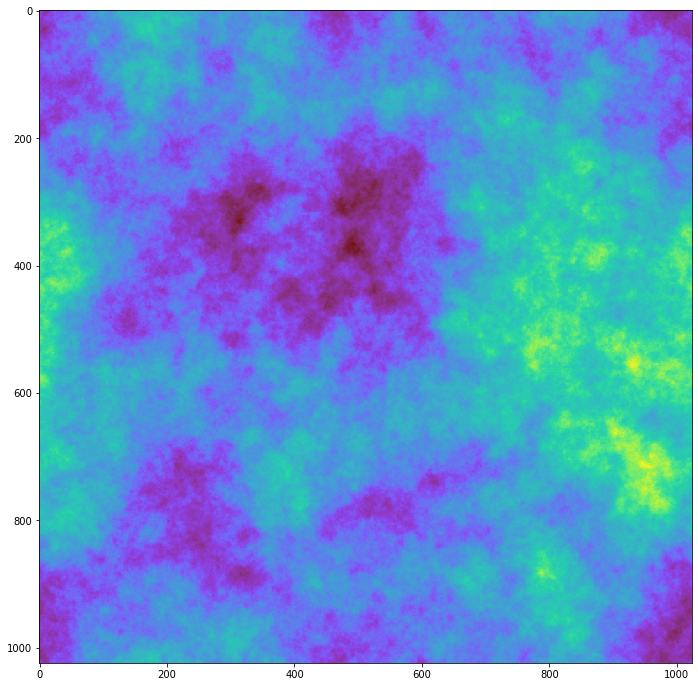

In [10]:
# We procedurally generate an image with an injected power spectrum.
# We'll make the spectrum a power law, with an exponent of -3.
# Try varying this parameter and see how it changes the image!
power=-3
res=1024
kx, ky= np.meshgrid(np.fft.fftfreq(res), np.fft.rfftfreq(res),
                   indexing='ij')
k=np.sqrt(kx**2+ky**2)
theta=2*np.pi*np.random.rand(*k.shape)
G=k**(power/2)*(np.cos(theta)+1j*np.sin(theta))
G[0,0]=0
generated_img=np.fft.irfft2(G,s=[res,res])
plt.figure(figsize=(12,12))
plt.imshow(generated_img)

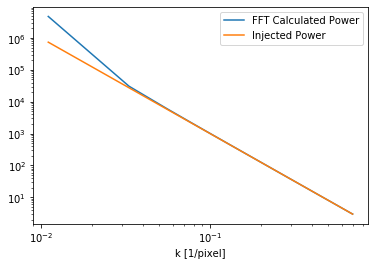

In [11]:
# Now that we have our generated image, we can write our algorithm to
# calculate the FFT power spectrum of the image.
from scipy.stats import binned_statistic
def get_power_spectrum_fft(img):
    img_k = np.fft.fft2(img)
    kx, ky = np.fft.fftfreq(img.shape[0]), np.fft.fftfreq(img.shape[1])
    kx, ky = np.meshgrid(kx, ky)
    k = np.sqrt(kx**2+ky**2)
    stat = binned_statistic(k.flatten(), np.abs(img_k.flatten())**2, bins=32, statistic='mean')
    bin_center = (stat.bin_edges[:-1]+stat.bin_edges[1:])/2
    return bin_center, stat.statistic

# Now, using this algorithm and comparing it to our injected spectrum
k, spectrum_fft=get_power_spectrum_fft(generated_img)
plt.loglog(k, spectrum_fft, label='FFT Calculated Power')
spectrum_inj=k**power
plt.loglog(k, spectrum_inj, label='Injected Power')
plt.legend()
plt.xlabel('k [1/pixel]')
plt.show()

This method works exceptionally well for all but the smallest values of k, when the spatial scale becomes of the same order of magnitude as the size of the image itself. However, this image isn't divided in any way. We want to be able to split the image into several annuli and calculate the power spectrum in any of the annuli. This division of the image can be accomplished via a mask.

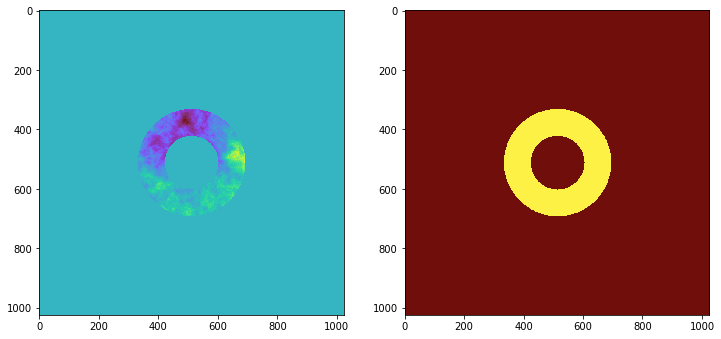

In [12]:
# Let's make a function to apply this mask. We want to create an image the
# same size as our generated or projected image where all points inside the
# mask are set to 1, and all points outside are set to 0.
def mask_annulus(img, inrad, outrad, width=None):
    # I include the width argument such that we can input the inner radius 
    # and outer radius of the image in kpc when we apply the mask to our 
    # simulation images later. The below if statement will handle the 
    # conversion to pixels.
    if width!=None:
        scale=img.shape[0]/width
        inrad=inrad*scale
        outrad=outrad*scale
    X, Y=np.meshgrid(range(img.shape[1]), range(img.shape[0]))
    center=[img.shape[0]/2, img.shape[1]/2]
    # We can use the numpy logic functions to create the mask 
    mask = np.logical_and(((X-center[1])**2+(Y-center[0])**2)>inrad**2,
                          ((X-center[1])**2+(Y-center[0])**2)<outrad**2)
    # Now we apply the mask to the image.
    masked_img=img.copy()
    masked_img[~mask]=0
    return masked_img, mask
# The function returns the image with the mask applied and the mask itself.
# Let's see how it works!
generated_ann, mask=mask_annulus(generated_img, 90, 180)
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(generated_ann)
plt.subplot(122)
plt.imshow(mask)

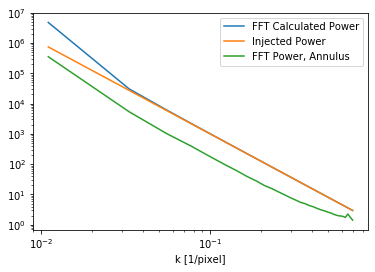

In [13]:
# Now that we have our masked image, let's try applying the FFT method
# to calculate its power spectrum.
plt.loglog(k, spectrum_fft, label='FFT Calculated Power')
plt.loglog(k, spectrum_inj, label='Injected Power')
k, spectrum_ann=get_power_spectrum_fft(generated_ann)
plt.loglog(k, spectrum_ann, label='FFT Power, Annulus')
plt.legend()
plt.xlabel('k [1/pixel]')
plt.show()

Clearly applying the mask has significantly changed the result of this power spectrum. This is because we are calculating the power of the entire image, not just of the portion of the image (inside the mask) that we are focusing on. Additionally, the mask will create some edge effects, which can be seen in the upper end of the k-axis. In order to mask the image without compromising our power spectrum calculation, we need to use a different method. The $\Delta$-variance method, utilizing a mexican hat filter, is designed especially for this purpose.

The mexican hat filter starts with a simple Gaussian in cartesian coordinates.
$$G_\sigma (x) = \frac{1}{(2 \pi \sigma^2)^{n/2}} e^{-\frac{x^2}{2\sigma^2}}$$
We can manipulate two such filters into selecting fluctions at a given scale $k_r$, with the filter $F_{k_r}(x)=G_{\sigma_1}-G_{\sigma_2}$ where $\sigma_1$ and $\sigma_2$ are separated by a chosen $\epsilon<<1$.$$\sigma_1=\frac{\sigma}{\sqrt{1+\epsilon}}\,\,\,\,\,\,\,\,\,\, 
\sigma_2=\sigma\sqrt{1+\epsilon}$$
and $k_r=(\sigma\sqrt{2\pi^2})^{-1} \approx 0.225/\sigma$

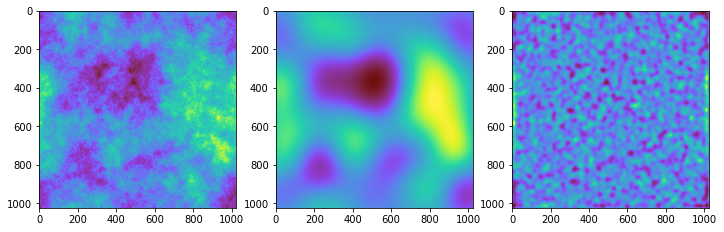

In [14]:
#We will first demonstrate this Gaussian filter on our generated image.
from astropy.convolution import convolve_fft, Gaussian2DKernel
plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(generated_img)
def mexican_hat(img, k):
    # In practice, we use an epsilon of 10^-3. Smaller is more accurate,
    # however there are diminishing returns after a point.
    epsilon=.001
    sigma=0.225/k
    
    G1 = Gaussian2DKernel(sigma/np.sqrt(1+epsilon))
    G2 = Gaussian2DKernel(sigma*np.sqrt(1+epsilon))
    F=G1-G2
    #We take our filter and convolve it with the power-law generated image
    convolved_img= convolve_fft(img, F,  normalize_kernel=False)
    return convolved_img
# We will make two images: one with fluctuations filtered for a small 
# wavefactor, and one with a large.
img_small_k=mexican_hat(generated_img, 0.002)
img_large_k=mexican_hat(generated_img, 0.02)
plt.subplot(132)
plt.imshow(img_small_k)
plt.subplot(133)
plt.imshow(img_large_k)

This function selects for and shows the image's structure at whatever value of k is supplied. A large value of k (small \sigma) gives small-scale fluctuations, while a small value of k (large \sigma) gives large-scale fluctuations. This filter can be easily corrected for the mask we apply to our images, giving the below filter, where M is the mask produced by our previous function.
$$S=\left( \frac{G_{\sigma 1}*I}{G_{\sigma 1}*M}-\frac{G_{\sigma 2}*I}{G_{\sigma 2}*M}\right) M$$
This filter is useful because we can vary the wavefactor over the same k-space as used by the FFT method. If we find the variance $V_{k_r}$ for each of these, we can recreate the power spectrum.
$$V_{k_r}= \int(S)^2d^2x=\epsilon^2P(k_r)n(\frac{n}{2}+1)2^{-\frac{n}{2}-1}\pi^\frac{n}{2}k_r^n$$
Where $P(k_r)$ is the power of the image, n is the dimension (2 in this case).

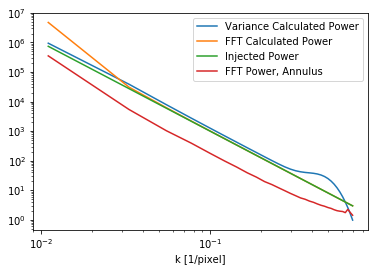

In [15]:
# Let's make a function to determine the power spectrum of a masked image
# using our new variance method
def get_power_spectrum_variance(img, ks, mask=None):
    #ks will be an array of our desired wavefactors in units of 1/pixel
    P=np.zeros(len(ks))
    epsilon= 0.001
    if mask is None or mask.shape != img.shape:
        mask=np.ones(img.shape)
    #We will use a for loop to iterate through ks and calculate the power
    for i, k in enumerate(ks):
        sigma= 0.225/k
        
        G1=Gaussian2DKernel(sigma/np.sqrt(1+epsilon))
        #Here we have G1*I and G1*M
        convolved_img1 = convolve_fft(img, G1)
        convolved_mask1 = convolve_fft(mask, G1)
        
        G2 = Gaussian2DKernel(sigma*np.sqrt(1+epsilon))
        #and here is G2*I and G2*M
        convolved_img2 = convolve_fft(img, G2)
        convolved_mask2 = convolve_fft(mask, G2)
        S=np.nan_to_num(convolved_img1/convolved_mask1-convolved_img2/convolved_mask2)*mask
        # Vk has to also be normalized by the area of the original
        # image/the area of the mask.
        Vk=np.sum(np.ones(img.shape))/np.sum(mask)*np.sum(S**2)
        P[i]=Vk/(epsilon**2*k**2*np.pi)
    return P

# Using the k-space provided by our earlier attempts,
# let's look at what this new function delivers.
spectrum_var= get_power_spectrum_variance(generated_ann, k, mask=mask)
plt.loglog(k, spectrum_var, label='Variance Calculated Power')
plt.loglog(k, spectrum_fft, label='FFT Calculated Power')
plt.loglog(k, spectrum_inj, label='Injected Power')
plt.loglog(k, spectrum_ann, label='FFT Power, Annulus')
plt.legend()
plt.xlabel('k [1/pixel]')
plt.show()

This is about as good as the FFT method, however we are having the opposite problem. The FFT method breaks down at large scales, while the variance method is having more trouble at small scales. On the right hand side of the spectrum, above $k=0.3$, the scale $\sigma$ of the Gaussian kernel is smaller than 1 pixel, so it would make sense that the calculation would start to break down above about $k=0.225$. Still, it has clearly corrected for the effect the mask was having on spectrum.

We now have a well-developed implementation of the variance method for calculating the power spectrum of our synthetic x-ray maps. There is one more step before we can start retrieving data from the simulation, to normalize the image by the $\beta$-model. Such that the image is not entirely dominated by the large scale fluctuations (the radially decreasing density of the ICM), we can divide out a fitted $\beta$ model from each of our x-ray images. In relaxed galaxy clusters, the X-ray surface brightness of the ICM can typically be fit to the below function, with the central surface brightness $S_0$ and the core radius $r_c$.
$$ S= S_0\left[ 1+ \left( \frac{r}{r_c}\right)^2\right]^{-3 \beta +0.5}$$
This normalization has also been done in previous analysis of observational data from Zhuravleva et al. 2015 and Churazov et al. 2012, and removes any possible scaling factors from the length of observation and distance to the cluster.

Text(0.5, 0, 'Radius [$kpc$]')

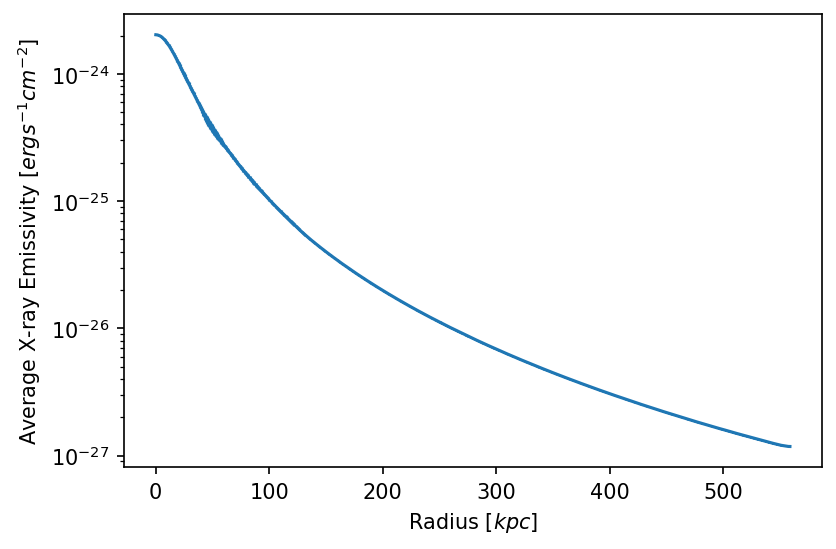

In [16]:
# To fit the beta model, we first need to azimuthally average the image,
# taking our 2D image and reducing it to a 1D function of radius by 
# dividing the image into many small annuli. For this, I used a function 
# found at https://www.lpl.arizona.edu/~ianc/python/radial_data.html
# Which I have put in the powerspectra.py repository for all functions
# in this demonstrative notebook.
from powerspectra import radial_data
# First, we apply this function to our projection
radial_prof=radial_data(proj)
# This profile object has several attributes that are useful.
# We use r (radius of each annulus), mean (mean of each annulus),
# and std (standard deviation of each annulus).
r=radial_prof.r
s_mean=radial_prof.mean
s_std=radial_prof.std
# We also need the dimensions of the image
dim=proj.shape
#First let's plot this profile, taking the standard deviation for errors.
# r is currently in pixels. Let's convert it to physical units.
# The domain of the simulation is 500 by 500 by 1000 kpc. The image is
# therefore 500 x 1000 kpc, so  we can divide by the dimensions in px and 
# multiply by the dimension in kpc
plt.errorbar(r*500/dim[0], s_mean, yerr=s_std)
plt.yscale('log')
plt.ylabel('Average X-ray Emissivity [$erg s^{-1} cm^{-2}$]')
plt.xlabel('Radius [$kpc$]')

Now that we have the radial data, we can fit our $\beta$-model to the azimuthally averaged profile of the cluster. To do this, we'll employ a Monte Carlo Markov chain. We will be using a similar algorithm later, so its a good idea to get familiar with it now. I highly recommend the tutorials [here](emcee.readthedocs.io/en/stable/tutorials/line/) if you are particularly interested. Essentially, this algorithm will explore the parameter space of our constants $S_0$, $r_c$, and $\beta$ in the model and find the most likely combination of parameters. It will also give us the codependencies of these parameters.

In [17]:
import emcee
from scipy.optimize import minimize
# Let's make a function that will handle the entire normalization, 
# given a projection and width (in kpc).
def beta_normalize(proj, width=500, nsteps=25000):
    # First we can retrieve the radial data and dimensions, as above.
    radial_prof=radial_data(proj)
    r=radial_prof.r
    s_mean=radial_prof.mean
    s_std=radial_prof.std
    dim=proj.shape
    # We can define a function that will compare our radial data to our
    # model, and return the likelihood that this model is correct.
    def log_likelihood(theta, r, s, serr):
        s0, beta, Rc, log_f=theta
        if Rc<0 or 3*beta<0.5:
            return -np.inf
        model=s0*(1+(r/Rc)**2)**(-3*beta+0.5)
        sigma2=serr**2+model**2*np.exp(2*log_f)
        return -0.5*np.sum((s-model)**2/sigma2 + np.log(sigma2))
    # The variable theta in this function will contain our parameters
    # We can now use this to find some starting values for the MCMC.
    nll= lambda *args: -log_likelihood(*args)
    initial=np.array([s_mean.max(), 0.53, dim[0]/width*26, np.log(.1)])
    soln=minimize(nll, initial, args=(r,s_mean,s_std)) 
    # The minimize function will step through each argument to find values
    # for our parameters in the soln variable. We also give an initial
    # guess, which is based on the simulation's initial beta model 
    # We now make a function to include priors, which are any hard limits
    # on the parameters. This isn't especially important in this 
    # application, however we will certainly use this later on.
    # For now we want to make sure our core radius is positive, and our
    # exponent remains negative.
    def log_prior(theta):
        s0, beta, Rc, log_f=theta
        if Rc>0 and 3*beta>0.5:
            return 0
        else:
            return -np.inf
    def log_probability(theta, r, s, serr):
        lp=log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp+log_likelihood(theta,r,s, serr)
    # This function essentially makes it so that if either prior is
    # violated, the likelihood of that combination of parameters becomes 
    # negative infinity, which the MCMC algorithm will throw out.
    pos = soln.x+ 1e-10* np.random.randn(32, 4)
    nwalkers,ndim=pos.shape
    sampler=emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                  args=(r,s_mean,s_std))
    sampler.run_mcmc(pos, nsteps, progress=True)
    flat_samples = sampler.get_chain(discard=500,thin=200,flat=True)
    mcs0, mcbeta, mcRc, mclogf= tuple([np.percentile(flat_samples[:, i], 50) for i in range(ndim)])
    # Now we have run the MCMC algorithm and it has found the most likely
    # values for each parameter. Let's pack them up in a dict.
    beta_params={'s0':mcs0,'beta':mcbeta, 'Rc': mcRc, 'logf':mclogf}
    # We can now create an image that follows the model, and divide
    # the original image by the beta model image.
    y=np.linspace(-dim[0]/2, dim[0]/2, dim[0])
    x=np.linspace(-dim[1]/2, dim[1]/2, dim[1])
    X, Y= np.meshgrid(x,y)
    r2=X**2+Y**2
    beta=mcs0*(1+r2/(mcRc**2))**(-3*mcbeta+0.5)
    normalized_proj=proj/beta
    
    return normalized_proj, beta_params, soln
# That's a long function! 

100%|██████████| 25000/25000 [05:13<00:00, 79.80it/s]


s0= 1.7472810427217096e-24 erg/s
beta= 0.6125982822292948
Rc= 37.39925463443505 kpc


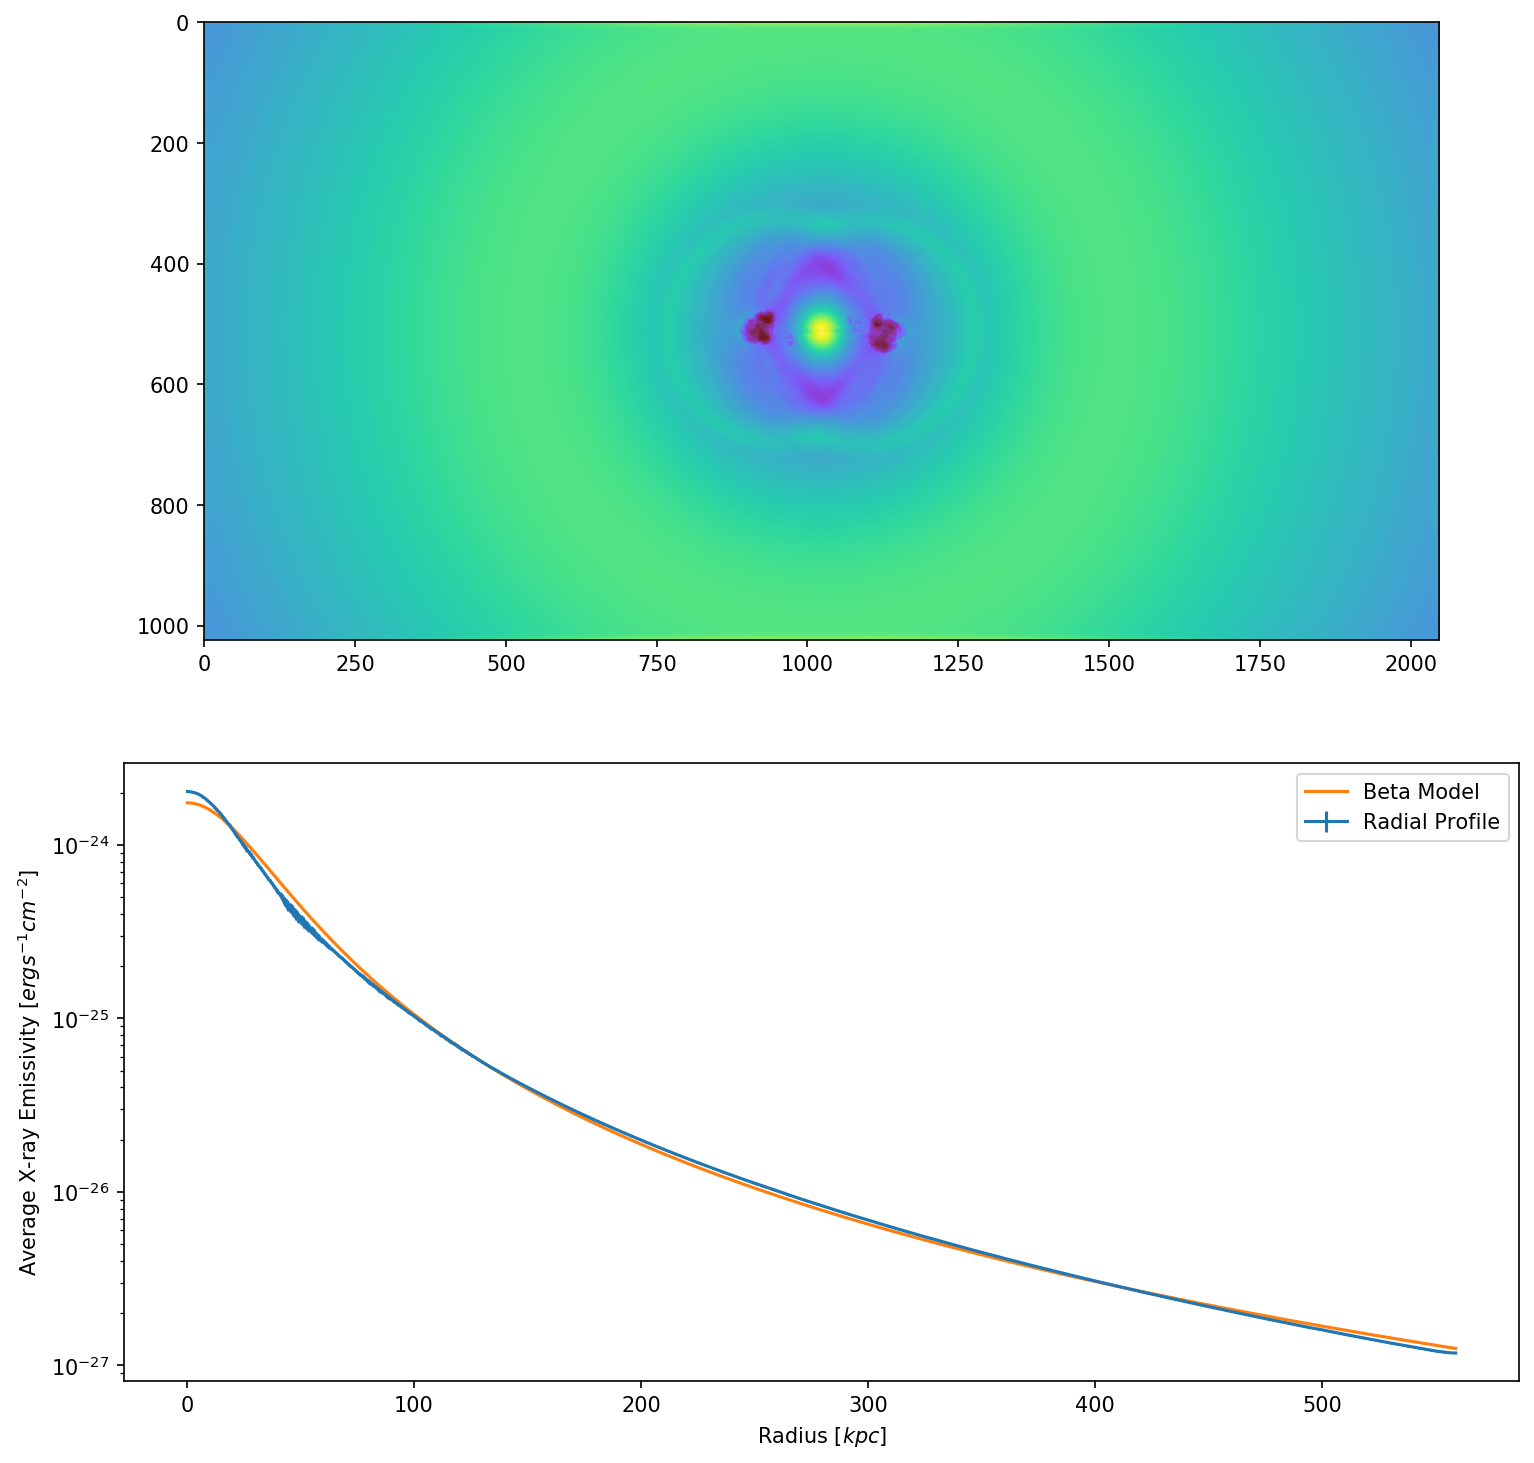

In [18]:
# Let's see what it can do!
normalized_proj, beta_params, soln = beta_normalize(proj)
# Let's also make a function that returns the beta-model given parameters
def model(r, params):
    s0=params['s0']
    beta=params['beta']
    Rc=params['Rc']
    return s0*(1+(r/Rc)**2)**(-3*beta+0.5)
beta_model=model(r,beta_params)

plt.figure(figsize=(12,12))
plt.subplot(211)
plt.imshow(normalized_proj)
plt.subplot(212)
plt.errorbar(r*500/dim[0], s_mean, yerr=s_std, label='Radial Profile')
plt.plot(r*500/dim[0], beta_model,label='Beta Model')
plt.yscale('log')
plt.legend()
plt.ylabel('Average X-ray Emissivity [$erg s^{-1} cm^{-2}$]')
plt.xlabel('Radius [$kpc$]')
print('s0=', beta_params['s0'], 'erg/s')
print('beta=', beta_params['beta'])
print('Rc=', beta_params['Rc']*500/proj.shape[0], 'kpc')

This is a pretty good fit, and clearly can recreate the radial profile of our simulated X-ray image. The normalized image also clearly shows the substructure, including the plume of the jet as well as the bubble wall, in sharper contrast now that the unperturbed large-scale variation has been removed.

We have to make one more change to our power spectrum function in order to use the data properly. In this work, we don't actually look at the power spectrum but rather the amplitude of density fluctuations. This conversion is fairly simple, using the core radius $r_c$ found in the above $\beta$-model fit, and the wavefactor k.
$$A_{3D}=\frac{\delta \rho}{\rho}=\sqrt{P k^3/r_c}$$
This density fluctuation spectrum can also be related to the 1-dimensional velocity spectrum $V_{1,k}= c_s \frac{A_{3D}}{\eta}$ via the sound speed $c_s$ and $\eta=1\pm0.3$. This can be compared to measured velocity dispersions, but the uncertainty of $\eta$ makes this quantity less useful for our purposes.

Text(0, 0.5, '$A_{3D}=\\frac{\\delta \\rho}{\\rho} $')

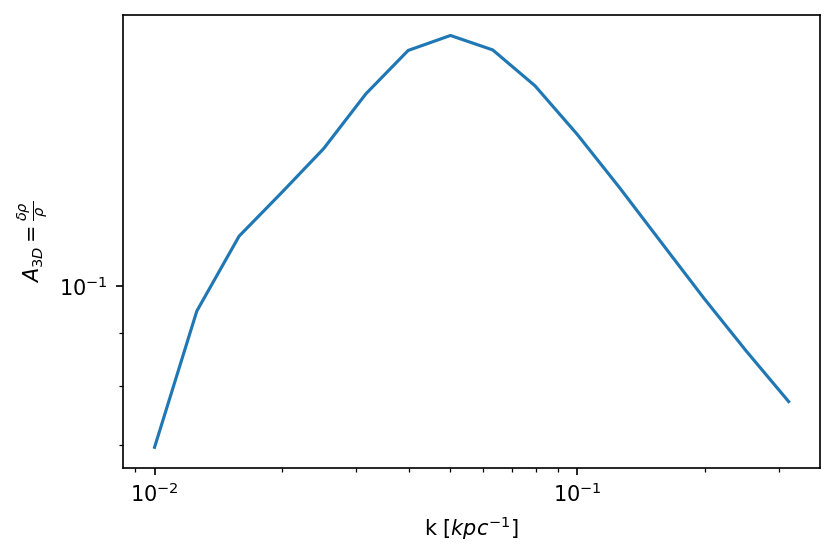

In [19]:
def get_amplitude_spectrum(img, kkpc, width=500, Rc=26, mask=None):
    # This function is essentially identical to the variance method, 
    # with the final conversion described above. It also has parameters for
    # using physical units (kpc) instead of pixels. Our array of k-values is 
    # now input in units of 1/kpc, while the width and core radius are in kpc.
    A = np.zeros(len(kkpc))
    scale=img.shape[0]/width
    ks=kkpc/scale
    epsilon = 0.001
    for i, k in enumerate(ks):
        sigma = 0.225/k
        if mask is None or mask.shape != img.shape:
            mask = np.ones(img.shape)

        G1 = Gaussian2DKernel(sigma/np.sqrt(1+epsilon))
        convolved_img1 = convolve_fft(img, G1)
        convolved_mask1 = convolve_fft(mask, G1)
        G2 = Gaussian2DKernel(sigma*np.sqrt(1+epsilon))
        convolved_img2 = convolve_fft(img, G2)
        convolved_mask2 = convolve_fft(mask, G2)
        S = np.nan_to_num((convolved_img1/convolved_mask1-convolved_img2/convolved_mask2)*mask)
        Vk = np.sum(np.ones(img.shape))/np.sum(mask)*np.sum(S**2)
        
        P = Vk/epsilon**2/k**2/np.pi
        A[i]= np.sqrt(P*k**3/(Rc*scale))
    return A
# So we have our image with applied mask, we can create a kkpc in logarithmic
# space. The width is 500 kpc for our all-domain images, and the core radius
# is found from the beta-model. We have everything we need!
kkpc=np.logspace(-2, -0.5, 16)
# Now that we have our normalized image, we mask an annulus from 31-62 kpc.
normalized_ann, mask=mask_annulus(normalized_proj, 31, 62, width=500)
spectrum_amp=get_amplitude_spectrum(normalized_ann, kkpc,
                                    Rc=beta_params['Rc'], mask=mask)
plt.loglog(kkpc,spectrum_amp)
plt.xlabel('k [$kpc^{-1}$]')
plt.ylabel('$A_{3D}=\\frac{\delta \\rho}{\\rho} $')

This looks like what we would expect, with a clear peak at 20 kpc ($k=0.05$ kpc), while the observed spectra of Zhuravleva et al. 2015 peaks between 50 and 100 kpc. The form of the spectra are visually similar. This is a fairly low-resolution spectrum for this demonstration, so we will use the provided spectra in this directory, which has been pre-calculated using these functions.

In [20]:
# The specta are organized by annulus in a few csv files in this directory.
# Let's unpack one of them now. We'll use the 2nd, which is 31-62 kpc.
import pandas as pd
annulus_2=pd.read_csv('ann2.csv')
annulus_2

,Unnamed: 0,k,obs_mean,obs_max,obs_min,10_myr,20_myr,30_myr,40_myr,50_myr,60_myr,70_myr,80_myr
0,0,0.006305,0.096256,0.107789,0.081778,0.017233,0.045358,0.013188,0.044358,0.087213,0.066196,0.039696,0.028580
1,1,0.006942,0.103222,0.115667,0.090267,0.021177,0.053147,0.014783,0.056617,0.102456,0.076981,0.046951,0.035193
2,2,0.007642,0.112111,0.125333,0.098244,0.025111,0.059498,0.019978,0.069164,0.114748,0.085438,0.053941,0.042693
3,3,0.008413,0.121889,0.135111,0.108222,0.028988,0.064028,0.029935,0.081432,0.123085,0.091088,0.061039,0.051366
4,4,0.009261,0.131778,0.144111,0.119222,0.033051,0.066907,0.043971,0.093261,0.127401,0.094306,0.068867,0.061204
5,5,0.010200,0.140667,0.153667,0.128111,0.037751,0.068836,0.061165,0.105004,0.128627,0.096335,0.077866,0.071818
6,6,0.011220,0.148000,0.162222,0.136222,0.043413,0.070875,0.080414,0.117000,0.128520,0.098969,0.087775,0.082301
7,7,0.012360,0.153333,0.167111,0.140333,0.050425,0.074377,0.101660,0.130217,0.129324,0.104133,0.098341,0.092210
8,8,0.013600,0.156667,0.170000,0.143778,0.058484,0.081093,0.123466,0.144343,0.133509,0.113219,0.108790,0.100838
9,9,0.014980,0.157778,0.169778,0.143778,0.067824,0.090422,0.146887,0.161086,0.141723,0.125467,0.118371,0.108033


Text(0, 0.5, '$A_{3D}=\\frac{\\delta \\rho}{\\rho} $')

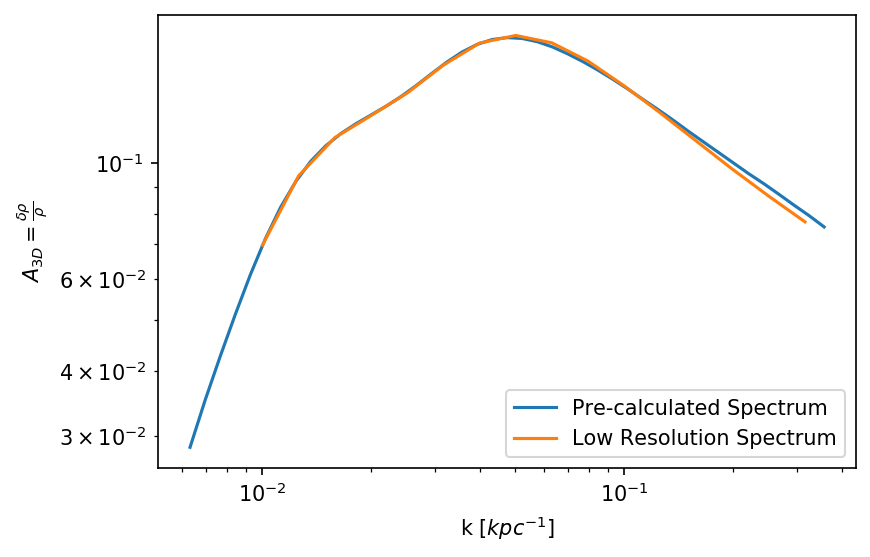

In [21]:
# This is a pandas Dataframe, which works well for storing data in a table
# We can take out individual columns and convert them to numpy arrays
k=annulus_2['k'].to_numpy()
spectrum_pre=annulus_2['80_myr'].to_numpy()
plt.loglog(k, spectrum_pre, label='Pre-calculated Spectrum')
# Let's also plot the spectrum we just calculated, to prove to ourselves
# that the methods we have just gone over are the same that produced 
# the data provided in the directory.
plt.loglog(kkpc,spectrum_amp, label='Low Resolution Spectrum')
plt.legend()
plt.xlabel('k [$kpc^{-1}$]')
plt.ylabel('$A_{3D}=\\frac{\delta \\rho}{\\rho} $')

We can use all of this data to form a composite spectrum for each annulus. Because the cluster has undergone multiple periods of jet activity, along with other processes contributing to the X-ray fluctuations. Our data only simulates a single period of jet activity. We can model a combination of multiple jets with a linear combination of our spectra. We will use the same MCMC algorithm as in the $\beta$-model fitting to determine the coefficients for each simulation time. We will sample the simulation from when it shuts off at 10 Myr to 80 Myr. We essentially want to fit the observational data to a composite spectrum, such that $A_{comp}= \sum\limits_{t} \alpha_t A_{3D}(t)$, where we fit the $\alpha$ coefficient for each of our sampled simulation times.

In [22]:
# The easiest way to organize the data such that the 1st annulus at 10 Myr
# has the same coefficient as the 2nd annulus at 10 Myr is to concatenate
# the spectra together. We can prepare the data using the below function.
def concatenate_data(key, max_ann=2):
    data=[]
    for a in range(max_ann):
        annulus_data=pd.read_csv('ann'+str(a+1)+'.csv')
        spectrum=annulus_data[key].to_numpy()
        data.append(spectrum)
    return np.concatenate(tuple(data))
# This function creates an empty list, populates that list with data, then
# concatenates each element of the list together in a final numpy array.

In [23]:
# Let's prepare the data now!
times=['10','20','30','40','50','60','70','80']
spectra={}
for t in times:
    spectra[t]=concatenate_data(t+'_myr', max_ann=2)
# spectra is now a dict containing all the data in the first two annuli
# We also need the bounds on the target data for the fit, these being the 
# obs columns in the supplied csv files. This data is from Zhuravleva 2015
y=concatenate_data('obs_mean')
yerr=concatenate_data('obs_max')-concatenate_data('obs_min')
k=concatenate_data('k')
# We start the MCMC in the same way, defining the likelihood function.
def log_likelihood(theta, k, y, yerr):
    log_f=theta[len(times)]
    model=sum([theta[times.index(t)]*spectra[t] for t in times])
    sigma2=yerr**2 + model**2*np.exp(2*log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
#This is fairly similar to the previous likelihood function, however we 
# have unpacked our parameters in theta differently.
# We have to set priors in this implementation such that none of the
# spectral coefficients are negative.
def log_prior(theta):
    # The spectral coefficients are all but the last parameter in theta
    if min(theta[:-1])>0:
        return 0
    else:
        return -np.inf
def log_probability(theta, k, y, yerr):
    lp=log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp+log_likelihood(theta, k, y, yerr)

In [24]:
# We have to supply an initial guess for the parameters. 
# We give a conservative estimate for the fractional uncertainty f
# The spectral coefficients we can set to 0.1 across the board.
initial=np.array([.1,.1,.1,.1,.1,.1,.1,.1, np.log(.5)])
pos = initial + 1e-4 * np.random.randn(32, 9)
nwalkers, ndim=pos.shape
sampler=emcee.EnsembleSampler(nwalkers,ndim, log_probability, args=(k,y,yerr))
sampler.run_mcmc(pos, 25000, progress=True)

100%|██████████| 25000/25000 [01:35<00:00, 260.54it/s]


State([[ 1.26432295e-01  1.10288847e-02  8.96427164e-02  5.96284869e-03
   3.99878061e-01  8.83970125e-02  1.54354282e-01  2.14503193e-02
  -9.30391113e-01]
 [ 1.42010408e-01  1.93814534e-02  2.11093198e-02  1.54339945e-01
   3.67988584e-01  3.69791866e-03  2.38377673e-02  5.34448232e-02
  -1.31016542e+00]
 [ 1.29365614e-01  1.00473850e-02  1.75143602e-02  2.59725805e-02
   6.11413128e-01  1.12062042e-03  9.45619052e-03  3.39930313e-02
  -1.35396875e+00]
 [ 1.21155798e-01  6.84827228e-03  2.85982642e-02  1.92852254e-03
   5.93142759e-01  5.73036870e-02  1.08205067e-02  5.48688117e-02
  -1.18455207e+00]
 [ 1.66185878e-01  2.48894703e-03  2.62607701e-02  9.51667307e-02
   4.75364737e-01  4.28507877e-03  2.14266069e-02  2.01964514e-02
  -1.32643280e+00]
 [ 1.48050686e-01  1.12451670e-02  1.58215392e-02  1.80025799e-02
   4.35732095e-01  3.42607471e-02  3.87447504e-02  1.23567268e-01
  -1.00249964e+00]
 [ 4.23930574e-02  4.97794522e-02  4.97662987e-02  1.88927675e-02
   6.60277908e-01  4.7

In [25]:
# Let's check to see if 25000 was enough iterations. tau is the
# autocorrection time, the number of iterations it takes for the sampler
# to "forget" the inital guess we gave
tau = sampler.get_autocorr_time()
print(tau)
#It takes about 400 iterations, emcee prefers to have N>50*tau.

[363.66889096 368.0606053  393.96465024 354.54337363 378.10731893
 391.77513063 414.58433434 443.44705195 409.38383775]


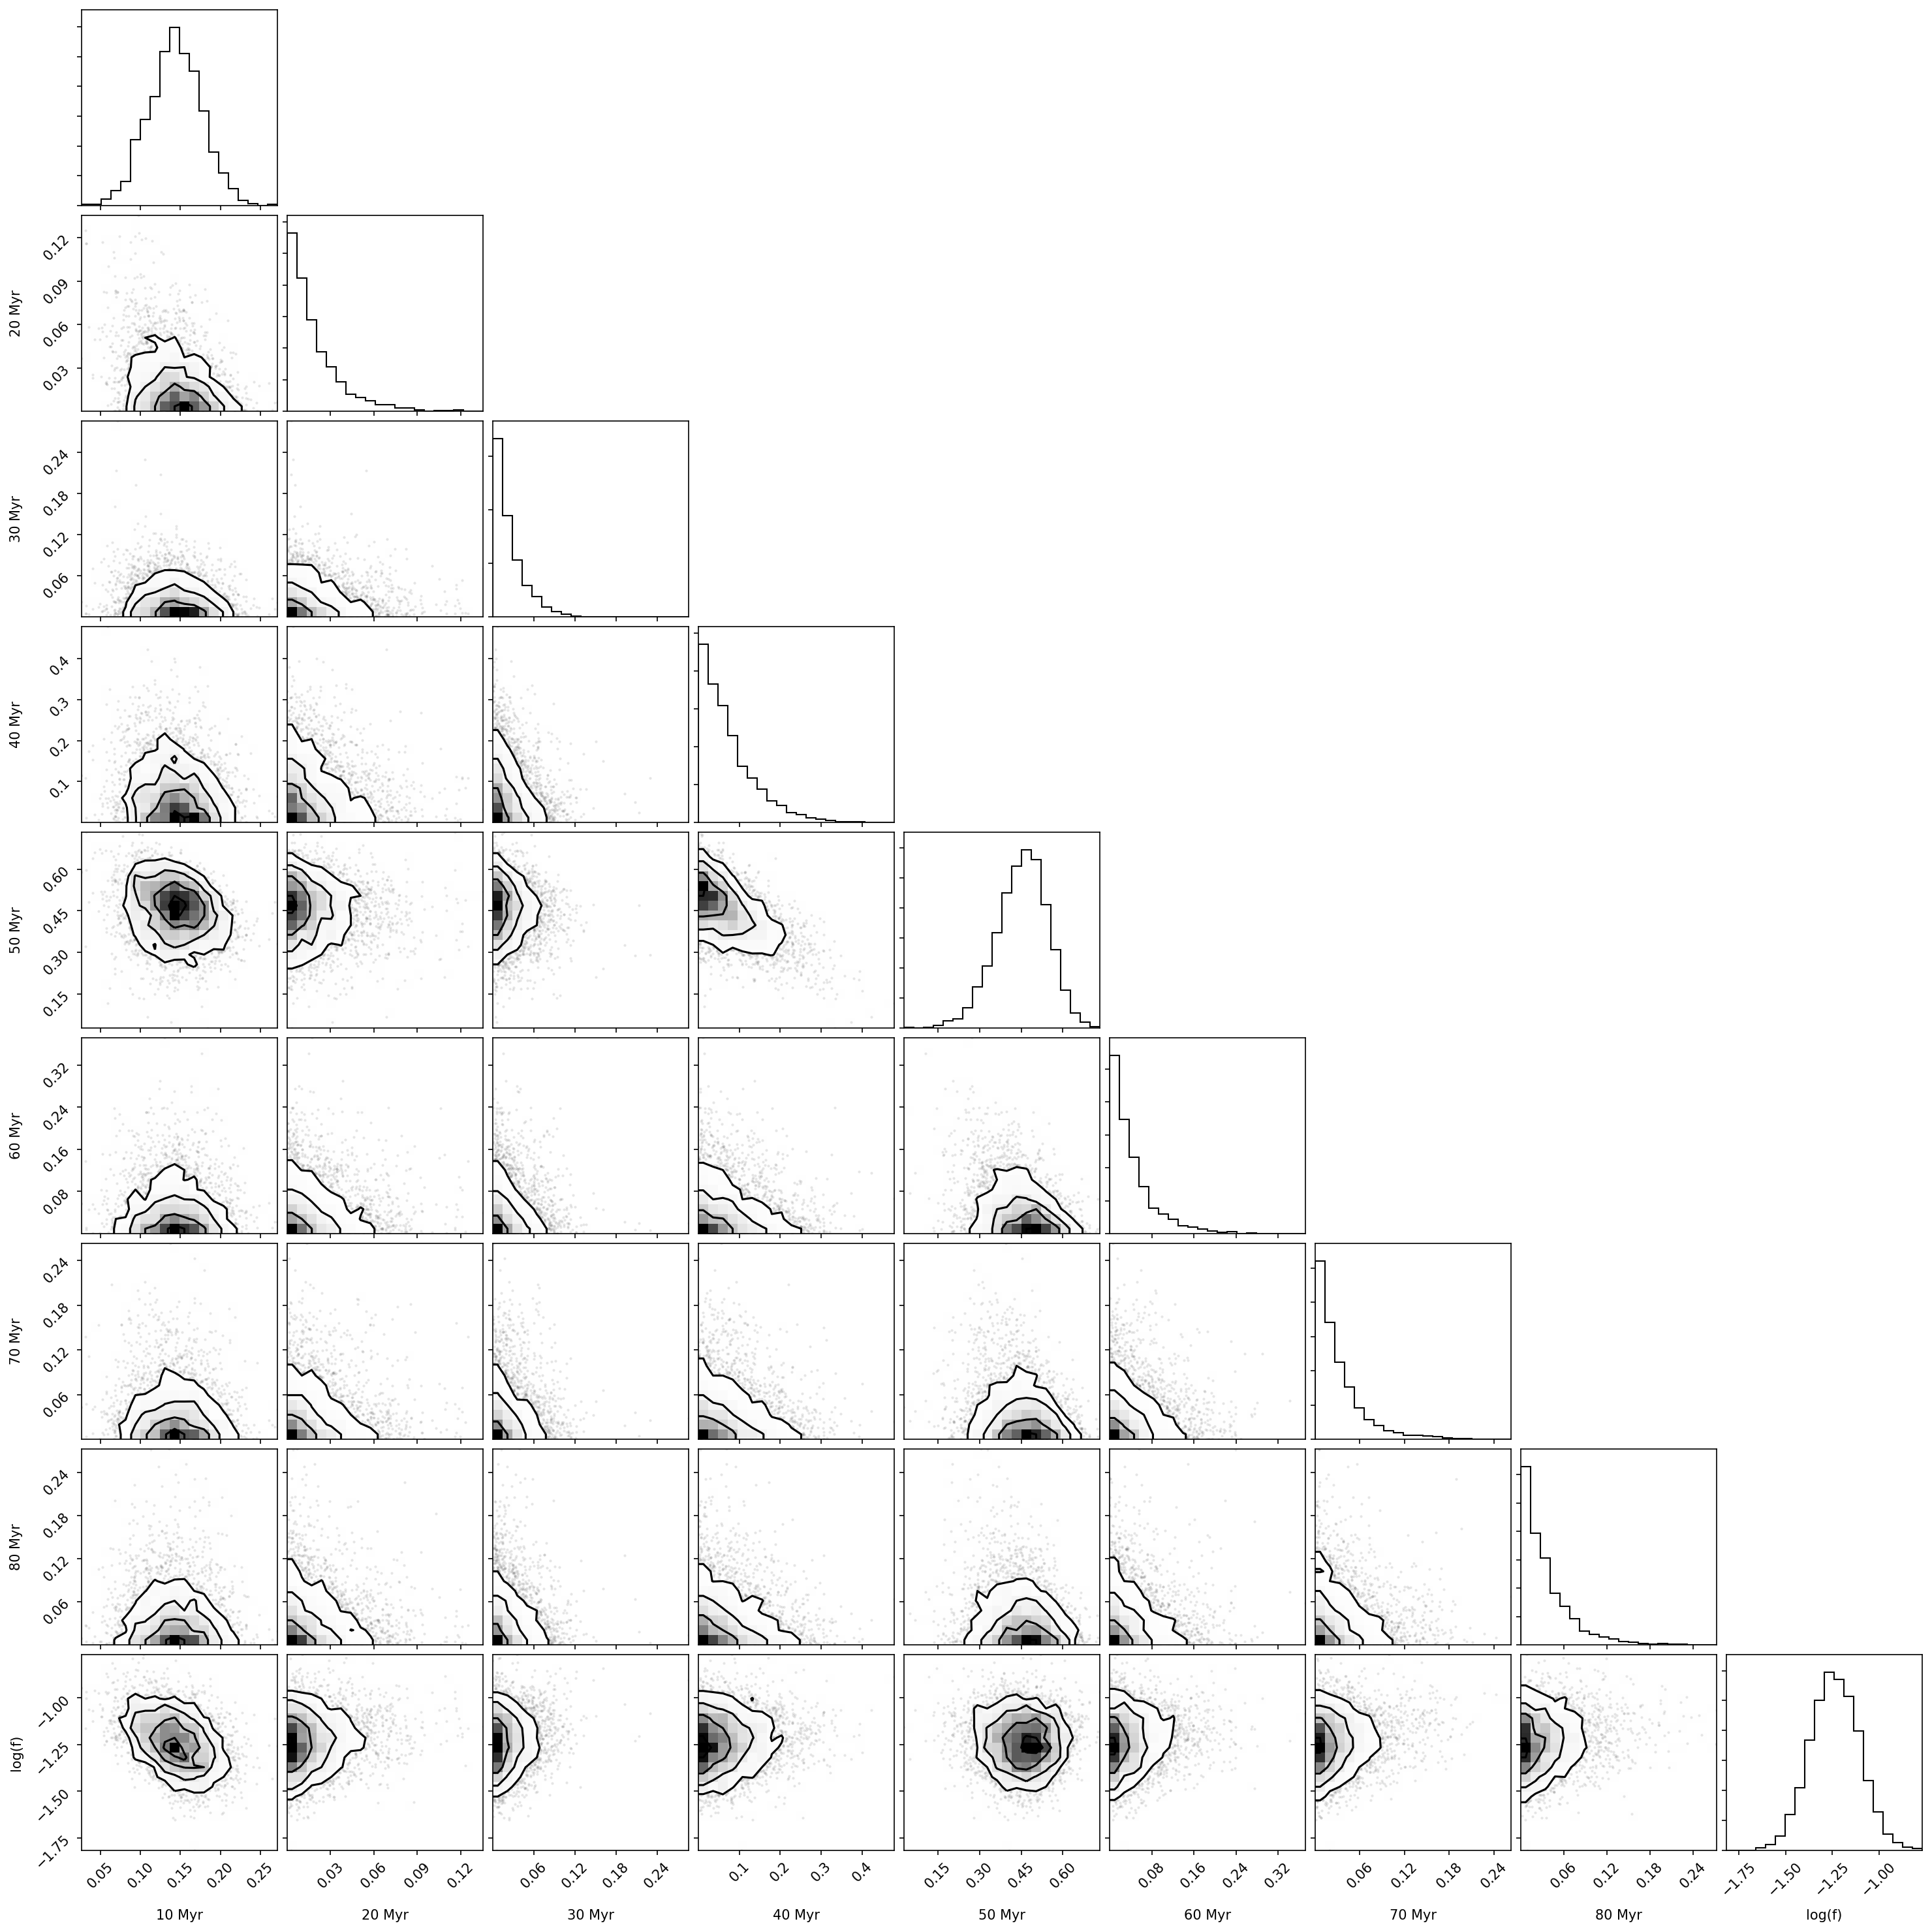

In [26]:
#Let's look at what we got from the MCMC sampler!
#It's good practice to discard the first 3*tau iterations and thin by tau/2
flat_samples = sampler.get_chain(discard=1200, thin=200, flat=True)
# Visualizing with a corner plot makes it easy to see the covariances
# of each parameter. Each column also has a histogram of all iterations.
import corner
labels = ['10 Myr', '20 Myr', '30 Myr', '40 Myr', '50 Myr', 
          '60 Myr', '70 Myr', '80 Myr', 'log(f)']
fig = corner.corner(flat_samples, labels=labels)

In [44]:
# Let's see what this composite spectrum actually looks like!
params={}
# We'll loop through each of our parameters grabbing the fitted values
for i in range(ndim):
    mcmc_results=np.percentile(flat_samples[:,i],[16,50,84])
    mcmc_sigma=np.diff(mcmc_results)
    d={'best':mcmc_results[1], 
       'lower':mcmc_sigma[0], 'upper':mcmc_sigma[1]}
    params[labels[i]]=d
mcmc_params=pd.DataFrame(params)
mcmc_params
# 'best' is the best fit according to mcmc, with upper and lower
# uncertainties also included in this table.

,10 Myr,20 Myr,30 Myr,40 Myr,50 Myr,60 Myr,70 Myr,80 Myr,log(f)
best,0.144168,0.012707,0.017030,0.055944,0.458338,0.029764,0.022130,0.024686,-1.237080
lower,0.034388,0.009377,0.012500,0.041154,0.095683,0.021848,0.016746,0.018633,0.130488
upper,0.031839,0.020683,0.027476,0.078862,0.083663,0.048300,0.035199,0.038708,0.132595


Text(0.5, 0, 'k [$kpc^{-1}$]')

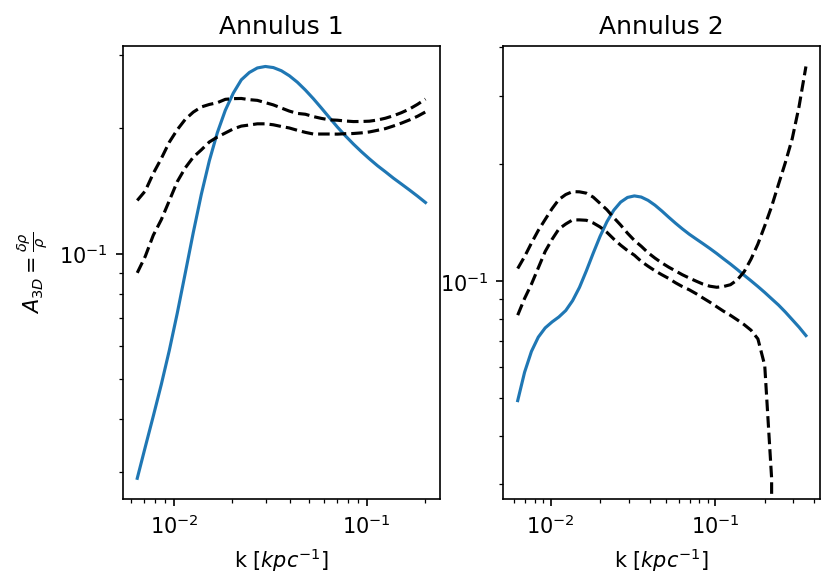

In [55]:
composite_terms=[mcmc_params[t+' Myr']['best']*spectra[t] for t in times]
spectrum_comp=sum(composite_terms)
#We have to unconcatenate the data, so we will reload the k-array
k_ann1=pd.read_csv('ann1.csv')['k']
k_ann2=pd.read_csv('ann2.csv')['k']
#We also need the observed maximum and minimum x-ray fluctuations
obs_max=concatenate_data('obs_max')
obs_min=concatenate_data('obs_min')

plt.subplot(121)
plt.loglog(k_ann1, spectrum_comp[:len(k_ann1)])
plt.loglog(k_ann1, obs_max[:len(k_ann1)], linestyle='dashed', color='black')
plt.loglog(k_ann1, obs_min[:len(k_ann1)], linestyle='dashed', color='black')
plt.title('Annulus 1')
plt.ylabel('$A_{3D}=\\frac{\delta \\rho}{\\rho} $')
plt.xlabel('k [$kpc^{-1}$]')

plt.subplot(122)
plt.loglog(k_ann2, spectrum_comp[-len(k_ann2):])
plt.loglog(k_ann2, obs_max[-len(k_ann2):], linestyle='dashed', color='black')
plt.loglog(k_ann2, obs_min[-len(k_ann2):], linestyle='dashed', color='black')
plt.title('Annulus 2')
plt.xlabel('k [$kpc^{-1}$]')


This MCMC fit has done its best to reproduce the shape and magnitude of the observed X-ray fluctuation spectrum. As can be seen, the overall shape of the spectra is found, with the caveat that the synthetic spectra is weaker at small values of k. More discussion of our findings is seen in Heinrich et al. 2021